# AE98 CO<sub>2</sub> Profile Analysis

### Notebook Objectives:
<ol>
<li>Process and calibrate raw intensity data from the experiment</li>
<li>Determine the spot size and Rayleigh length of the beam</li>
<li>Calculate ADK ionization contours in the transverse and longitudinal planes</li>
</ol>

## Image Processing

The CO<sub>2</sub> data is stored in the <code>.bgData</code> format given by the BeamGage software. The <code>CO2Profile</code> class stored in <code>co2_ionization.py</code> is designed to parse this data into numpy arrays that can be easily manipulated in Python, and contains functions for calibrating and analyzing the profile data.

_Note: In order to parse these data files they need to have the <code>.h5</code> file extension. I made a copy of each file and renamed them separately._

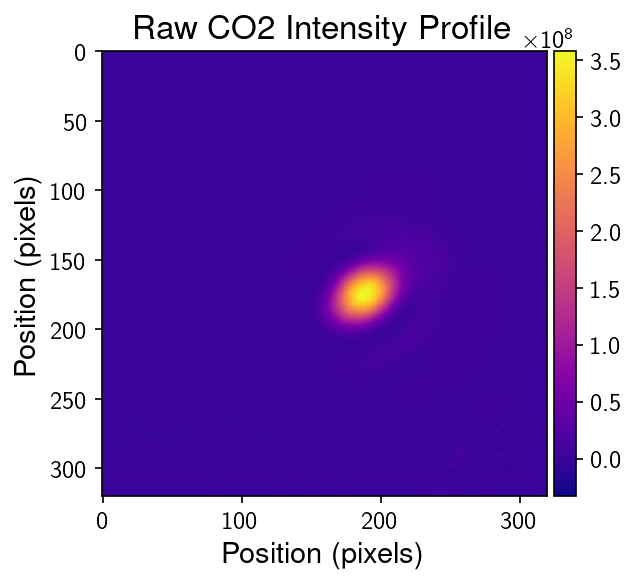

In [1]:
# Import my modules for analyzing CO2 profile data and calculating beam parameters
import co2_ionization as co2
import spot_analysis

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams['figure.dpi']= 150
import astropy.units as u

# Define path to data file
directory = "/home/oods/Research/AE98-99/CO2 Profiles/AE98/"
fname = directory + "2021-08-05 007 regen focus.h5"

# Define known beam parameters
total_energy = 200 * u.mJ   # total energy
pulse_length = 2 * u.ps     # pulse length
lambda_0 = 9.6 * u.um       # central wavelength of the laser

# CO2 spot size is known to be around 50 micron at the focus, scaling 1/40 from camera to focal plane
focus_scale = 1/40          # scaling factor between imaging plane and focal plane

# Open data file by initializing dataclass object, then display raw image
beam = co2.CO2Profile(fname, 
                      energy = total_energy, 
                      pulse_length = pulse_length,
                      lambda_0 = lambda_0,
                      focus_scale = focus_scale)
beam.image()

### Calibration

The intensity is calibrated using the total energy of the beam, such that integrating the scaled intensity over both space and time returns the correct total energy. In practice, this scaling factor is calculated using the pulse length and area of each pixel.

In [2]:
intensity_scale = ( total_energy / pulse_length / beam.pix_size**2 ).to(u.W / u.cm**2)

beam.calibrate_intensity(intensity_scale)

### Spot Analysis

The spot size and Rayleigh length are calculated using the script <code>spot_analysis.py</code>, which calulates the beam centroid, width, and tilt given an image of the beam spot.

#### Background Subtraction

Background is estimated by taking the mean signal in each of the corners of the image.

#### Total Power

The total power $P$ is obtained by integrating the irradiance $E(x,y)$ over the entire beam
\begin{align*}
P = \int_{-\infty}^\infty \int_{-\infty}^\infty  E(x,y)\,dxdy
\end{align*}

#### Beam Center
The center of the beam can be found by
\begin{align*}
x_c &= {1\over P} \int_{-\infty}^\infty \int_{-\infty}^\infty  x \cdot E(x,y)\,dxdy \\
y_c &= {1\over P} \int_{-\infty}^\infty \int_{-\infty}^\infty  y \cdot E(x,y)\,dxdy
\end{align*}

#### Variance
The beam spot is characterized by its variance in the $x$ and $y$ directions
\begin{align*}
\sigma_x^2 &= {1\over P} \int_{-\infty}^\infty \int_{-\infty}^\infty  (x-x_c)^2 E(x,y)\,dxdy \\
\sigma_y^2 &= {1\over P} \int_{-\infty}^\infty \int_{-\infty}^\infty  (y-y_c)^2 E(x,y)\,dxdy \\
\sigma_{xy}^2 &= {1\over P} \int_{-\infty}^\infty \int_{-\infty}^\infty  (x-x_c)(y-y_c) E(x,y)\,dxdy
\end{align*}

#### Beam Radius
For a Gaussian distribution centered at (0,0) with $1/e^2$ radius $w$

\begin{align*}
\sigma_x^2 = \frac{\int_{-\infty}^\infty \int_{-\infty}^\infty  x^2 e^{-2(x^2+y^2)/w^2}\,dx\,dy}{
\int_{-\infty}^\infty \int_{-\infty}^\infty e^{-2(x^2+y^2)/w^2}\,dx\,dy}
=\frac{w^2}{4}
\end{align*}

From here the beam radius is defined as
\begin{align*}
w_x = 2\sigma_x, \qquad w_y = 2\sigma_y
\end{align*}

where $w$ is related to the FWHM of a Gaussian by $\mathrm{FWHM} = w \sqrt{2\log 2}$.

For an elliptical spot, the major and minor axes are
\begin{align*}
r_x^2 &= 2(\sigma_x^2 + \sigma_y^2) + 2\operatorname{sign}(\sigma_x^2 -\sigma_y^2) \sqrt{(\sigma_x^2 -\sigma_y^2)^2+4\sigma_{xy}^4}\\
r_y^2 &= 2(\sigma_x^2 + \sigma_y^2) - 2\operatorname{sign}(\sigma_x^2 -\sigma_y^2) \sqrt{(\sigma_x^2 -\sigma_y^2)^2+4\sigma_{xy}^4}
\end{align*}

The tilt angle of the ellipse (measured counterclockwise from the $x$-axis) is then 
\begin{align*}
\varphi =\frac{1}{2}\arctan \frac{2\sigma_{xy}^2}{\sigma_x^2 -\sigma_y^2}
\end{align*}

#### Spot Analysis Algorithm

The spot analysis doesn't just calculate these beam parameters directly as outlined above. Instead, it iteratively improves the calculation by defining better and better regions over which to integrate. Functionally this means defining new rectangular masks to filter the image through that are tilted along the axis of the ellipse so the calculation of elliptical parameters is as accurate as possible.

The center of the beam ellipse is at (380 um, 345 um)
The ellipse radius (closest to horizontal) is 64 um
The ellipse radius (closest to vertical) is 40 um
The ellipse is rotated 35 deg ccw from horizontal


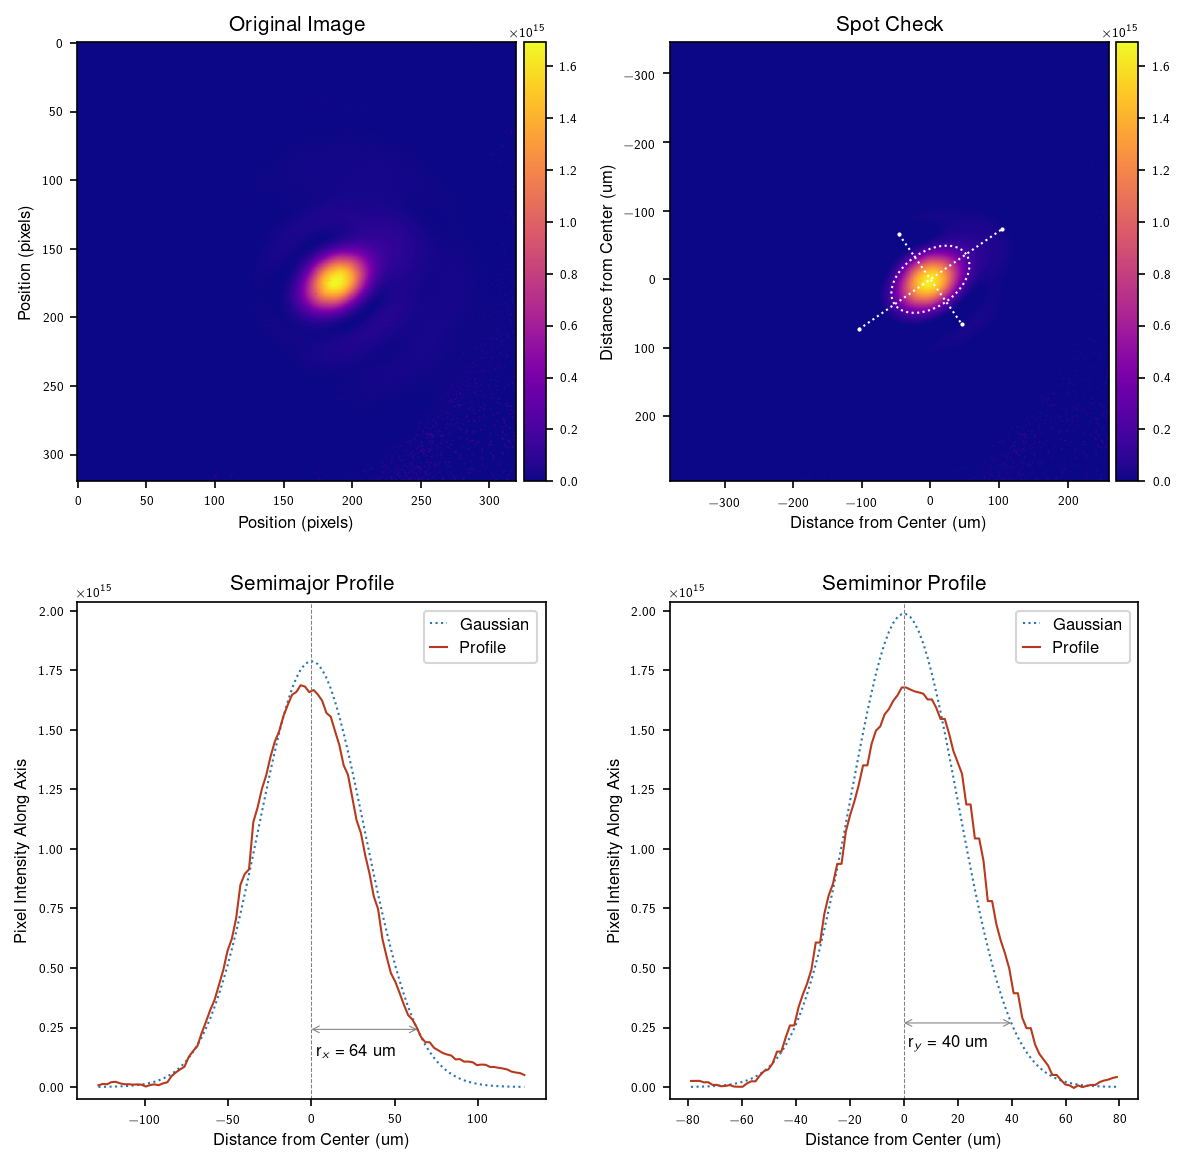

The spot size is 52 um


In [3]:
beam.analyze_spot()